In [9]:
""" import library and package dependencies """
import sys
sys.path.insert(0, '../src')
import os
import datetime
import pytz
from collections import namedtuple
from urllib.parse import quote
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from IPython.display import display, Markdown

from data_loader import load_data
from chart_format import StandardChart, LogChart, PercentileChart

In [10]:
df = pd.DataFrame()
# Restore dataframe from previous notebook
%store -r df

In [11]:
# Given price targets data is manually collected it is easier to use a markdown table than csv file
csv_file = '../data/tsla_PriceTargets.md'
# Read markdown table as csv format with '|' as separator and skip the row of '----' separators
dfTargets = pd.read_csv('../data/tsla_PriceTargets.md', sep='|', skipinitialspace=True, skiprows=[1])
# Drop the first and last (empty) columns due to how the markdown table is imported
dfTargets = dfTargets.iloc[:, 1:-1]  
# Remove leading/trailing white spaces from column names
dfTargets.columns = dfTargets.columns.str.strip()
# Remove leading/trailing white spaces from data
dfTargets = dfTargets.map(lambda x: x.strip() if isinstance(x, str) else x)
dfTargets['Date'] = pd.to_datetime(dfTargets['TargetDate'],dayfirst=True)
dfTargets['ForecastDate'] = pd.to_datetime(dfTargets['ForecastDate'],dayfirst=True)
dfTargets.set_index('Date', inplace=True)
dfTargets = dfTargets.sort_index()
#for col in dfTargets.columns:
#    print(f'{col}: {dfTargets[col].dtype}')


In [12]:
""" Adjust price targets for stock splits """

def adjust_price(row, date, multiplier):
    if row['ForecastDate'] < pd.to_datetime(date):
        row['Bear'] = (row['Bear'] / multiplier)
        row['Base'] = (row['Base'] / multiplier)
        row['Bull'] = (row['Bull'] / multiplier)
    return row

# 5-for-1 price split
dfTargets = dfTargets.apply(adjust_price, args=('2020-08-28', 5), axis=1)
# 3-for-1 price split
dfTargets = dfTargets.apply(adjust_price, args=('2022-08-25', 3), axis=1)


In [13]:
colors = {}
colors['tsla']='#3f77e4'
colors['ark']={
    'bear': 'darkorange',
    'base': '#888888',
    'bull': 'orange',
}
colors['other']=[
    'mediumseagreen',#'#3CB371',
    'olivedrab',#'#6B8E23',
    'green',#'#008000',
    'darkgreen',#'#006400',
    'mediumseagreen',#'#3CB371',
    'darkseagreen',#'#8FBC8F',
    'limegreen',#'#32CD32',
    'seagreen',#'#2E8B57',
    'forestgreen',#'#228B22',
    'yellowgreen',#'#9ACD32',
    'darkolivegreen',#'#556B2F',
    'olive',#'#808000',

    'springgreen',#'#00FF7F',
    'mediumspringgreen',#'#00FA9A',

    # light green colors
    'lightgreen',#'#90EE90',
    'palegreen',#'#98FB98',

    # bright green colors
    'greenyellow',#'#ADFF2F',
    'lawngreen',#'#7CFC00',
    'lime',#'#00FF00',
]



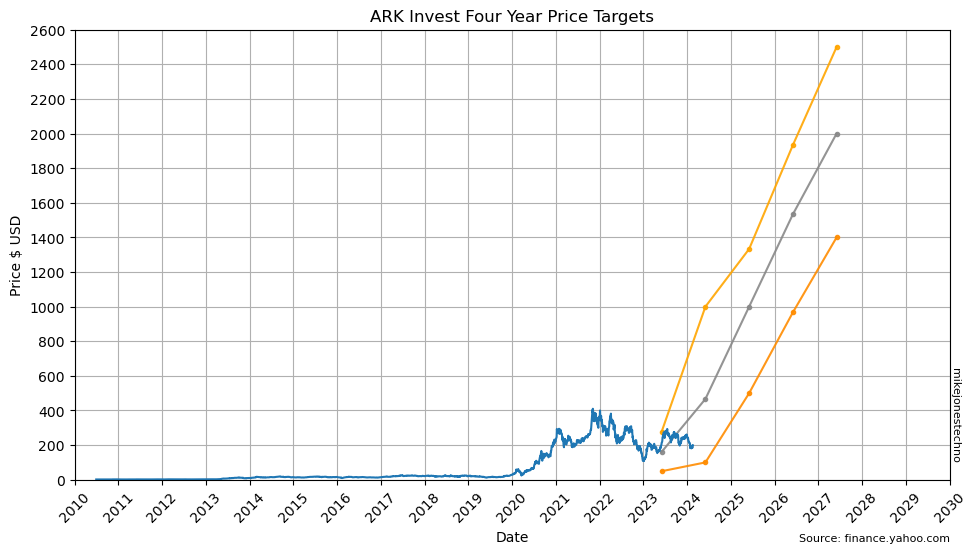

In [14]:
""" Extend simple chart with ARK price targets """
sx_symbol = 'TSLA'
data_column = 'Adj Close'
last_index = df[data_column].last_valid_index() # pandas timestamp

chart_params = {
    'chart_title': 'ARK Invest Four Year Price Targets', 
    'chart_source': 'Source: finance.yahoo.com', 
    'y_label': 'Price $ USD', 
    'y_ticks': 200,
    'x_label': 'Date', 
    'x_ticks': 1,
    'top_limit': 2600,
    'data_column': data_column
}

standard_chart = StandardChart(**chart_params)
plt, colors = standard_chart.base_chart(df)


name=['']
name[0] = 'ARKInvest'
line_color = {
    'bear': 'darkorange',
    'base': '#888888',
    'bull': 'orange',
}
line_alpha = 0.9
line_width = 1.5
dfTargets = dfTargets[dfTargets['Source'] == 'ARKInvest']

            
# Plot rolling ongoing forecast eg 4 year forecast updated each year
rolling_forecast = dfTargets.drop_duplicates(subset=['ForecastDate'])
if len(rolling_forecast) > 1:
    #if group['Bear'].notna().sum() > 1:
    plt.plot(rolling_forecast.index, rolling_forecast['Bear'], marker='.', label=name[0]+' Bear', color=line_color['bear'], alpha=line_alpha)
    #if group['Base'].notna().sum() > 1:
    plt.plot(rolling_forecast.index, rolling_forecast['Base'], marker='.', label=name[0], color=line_color['base'], alpha=line_alpha)
    #if group['Bull'].notna().sum() > 1:
    plt.plot(rolling_forecast.index, rolling_forecast['Bull'], marker='.', label=name[0]+' Bull', color=line_color['bull'], alpha=line_alpha)   

# plot actual price data last, so I can see it over the top of the target lines.
plt.plot(df.index, df[data_column], color=colors[0]['color'])

right_limit = pd.to_datetime(f'2028-01-01')
left_limit = pd.to_datetime(f'2010-01-01')
plt.xlim(left=left_limit, right=right_limit)    

plt.show()

Rather than zoom in on more recent 2019 I think the growth still looks surreal.
Replace the next chart with a copy of the S&P500 chart of real exponential growth, with context that it occurred over a multi-decade time period with median growth around 12% rather than the 18% that Tesla has to date.

Then a reminder of the S&P 500 log chart that shows a consistent and reasonably predictable straight line trend over multi-decade period. So FOR LONG TERM TRENDS we should show the log chart of Tesla and the ARK forecasts look much more sensible forecasts.

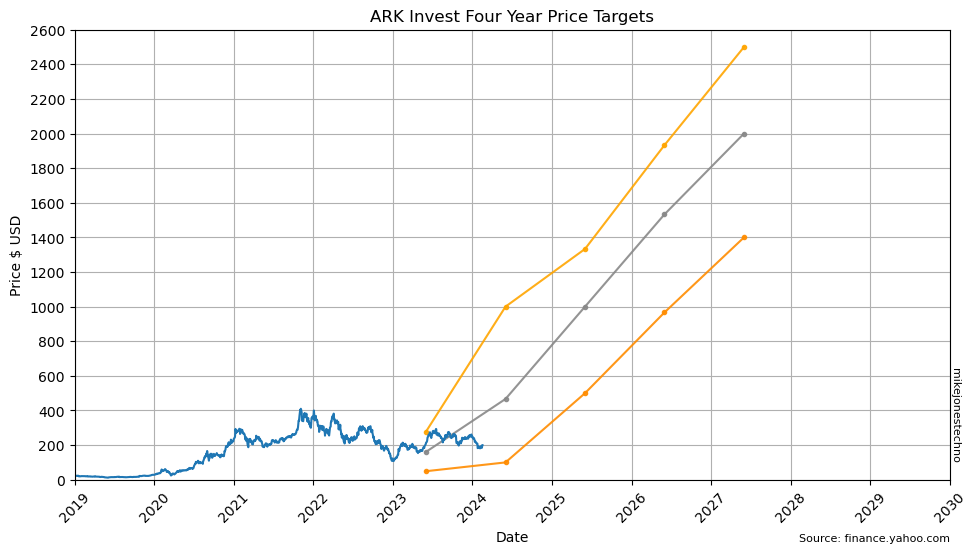

In [15]:
""" Extend simple chart with ARK price targets """
sx_symbol = 'TSLA'
data_column = 'Adj Close'
last_index = df[data_column].last_valid_index() # pandas timestamp

chart_params = {
    'chart_title': 'ARK Invest Four Year Price Targets', 
    'chart_source': 'Source: finance.yahoo.com', 
    'y_label': 'Price $ USD', 
    'y_ticks': 200,
    'x_label': 'Date', 
    'x_ticks': 1,
    'top_limit': 2600,
    'data_column': data_column
}

standard_chart = StandardChart(**chart_params)
plt, colors = standard_chart.base_chart(df)

name=['']
name[0] = 'ARKInvest'
line_color = {
    'bear': 'darkorange',
    'base': '#888888',
    'bull': 'orange',
}
line_alpha = 0.9
line_width = 1.5
dfTargets = dfTargets[dfTargets['Source'] == 'ARKInvest']

            
# Plot rolling ongoing forecast eg 4 year forecast updated each year
rolling_forecast = dfTargets.drop_duplicates(subset=['ForecastDate'])
if len(rolling_forecast) > 1:
    #if group['Bear'].notna().sum() > 1:
    plt.plot(rolling_forecast.index, rolling_forecast['Bear'], marker='.', label=name[0]+' Bear', color=line_color['bear'], alpha=line_alpha)
    #if group['Base'].notna().sum() > 1:
    plt.plot(rolling_forecast.index, rolling_forecast['Base'], marker='.', label=name[0], color=line_color['base'], alpha=line_alpha)
    #if group['Bull'].notna().sum() > 1:
    plt.plot(rolling_forecast.index, rolling_forecast['Bull'], marker='.', label=name[0]+' Bull', color=line_color['bull'], alpha=line_alpha)   

# plot actual price data last, so I can see it over the top of the target lines.
plt.plot(df.index, df[data_column], color=colors[0]['color'])

right_limit = pd.to_datetime(f'2028-01-01')
left_limit = pd.to_datetime(f'2019-01-01')
plt.xlim(left=left_limit, right=right_limit)    

plt.show()

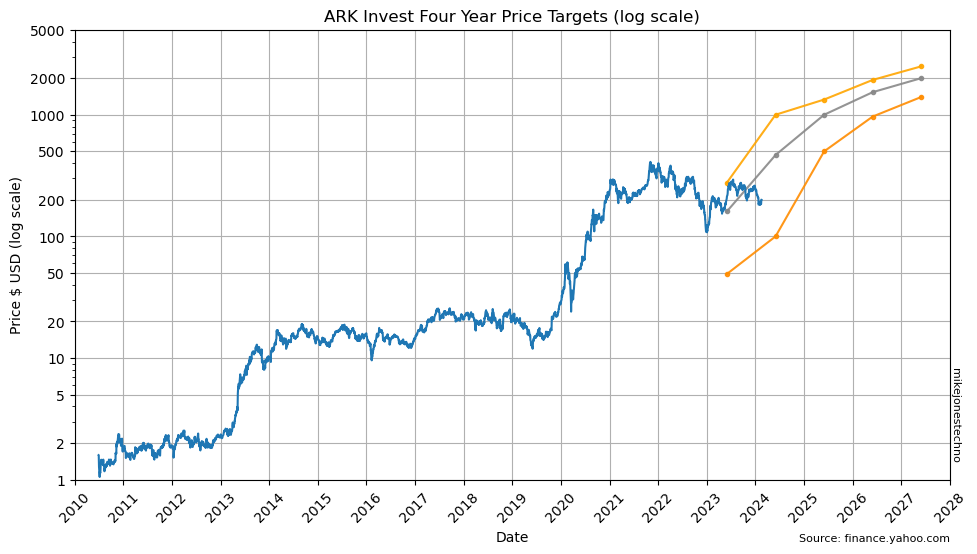

In [19]:
""" LOG SCALE with ARK price targets """

log_chart_params = chart_params.copy()
# remove parameters that are not relevant for log scale
log_chart_params.pop('y_ticks')
log_chart_params.pop('top_limit')
log_chart_params['chart_title'] = log_chart_params['chart_title'] + ' (log scale)'
log_chart_params['y_label'] = chart_params['y_label'] + ' (log scale)'
log_chart_params['y_ticks'] = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
log_chart = LogChart(**log_chart_params)
plt, colors = log_chart.base_chart(df)


name=['']
name[0] = 'ARKInvest'
line_color = {
    'bear': 'darkorange',
    'base': '#888888',
    'bull': 'orange',
}
line_alpha = 0.9
line_width = 1.5
dfTargets = dfTargets[dfTargets['Source'] == 'ARKInvest']

            
# Plot rolling ongoing forecast eg 4 year forecast updated each year
rolling_forecast = dfTargets.drop_duplicates(subset=['ForecastDate'])
if len(rolling_forecast) > 1:
    #if group['Bear'].notna().sum() > 1:
    plt.plot(rolling_forecast.index, rolling_forecast['Bear'], marker='.', label=name[0]+' Bear', color=line_color['bear'], alpha=line_alpha)
    #if group['Base'].notna().sum() > 1:
    plt.plot(rolling_forecast.index, rolling_forecast['Base'], marker='.', label=name[0], color=line_color['base'], alpha=line_alpha)
    #if group['Bull'].notna().sum() > 1:
    plt.plot(rolling_forecast.index, rolling_forecast['Bull'], marker='.', label=name[0]+' Bull', color=line_color['bull'], alpha=line_alpha)   

# plot actual price data last, so I can see it over the top of the target lines.
plt.plot(df.index, df[data_column], color=colors[0]['color'])

right_limit = pd.to_datetime(f'2028-01-01')
left_limit = pd.to_datetime(f'2010-01-01')
plt.xlim(left=left_limit, right=right_limit)    

plt.show()


# Extend the four year forecast to the end of the data
extendFourYear = True
# Show other forecasts (in addition to ARK)
showOther = True

if not showOther:
    dfTargets = dfTargets[dfTargets['Source'] == 'ARKInvest']

dfTargets = dfTargets.sort_values(['Source', 'ForecastDate', 'TargetDate'])

plt.figure(figsize=(10, 6))

grouped = dfTargets.groupby(['Source'])
for name, group in grouped:
    if name[0] == 'ARKInvest':
        line_color = colors['ark']
        line_alpha = 0.9
        line_width = 1.5
    else:
        rng_color = colors['other'].pop(0)
        colors['other'].append(rng_color)
        line_color = {
            'bear': rng_color,
            'base': rng_color,
            'bull': rng_color,
        }
        line_alpha = 0.8
        line_width = 1.0
        print(name[0]+ ' uses ' + rng_color)
            
    # Plot rolling ongoing forecast eg 4 year forecast updated each year
    rolling_forecast = group.drop_duplicates('ForecastDate')

    # Plot extended forecasts that have the same 'ForecastDate'
    extended_forecast = group.groupby(['ForecastDate'])


    for extended_name, subgroup in extended_forecast:
        if subgroup['Base'].notna().sum() > 1:
            if len(rolling_forecast) > 1:
                label_text = None # Hide label for extended forecasts if rolling forecast is also shown
            else:
                label_text = name[0]
            plt.plot(subgroup.index, subgroup['Base'], linestyle='dashed', marker=',', label=label_text, color=line_color['base'], alpha=line_alpha, linewidth=line_width)
        if subgroup['Bear'].notna().sum() > 1:
            subgroup_bear = subgroup.dropna(subset=['Bear'])
            if len(rolling_forecast) > 1:
                label_text = None # Hide label for extended forecasts if rolling forecast is also shown
            else:
                label_text = name[0]+' Bear'
            line_alpha = line_alpha * 0.8
            plt.plot(subgroup_bear.index, subgroup_bear['Bear'], linestyle='dashed', marker=',', label=label_text, color=line_color['bear'], alpha=line_alpha, linewidth=line_width)



    if len(rolling_forecast) > 1:
        if group['Bear'].notna().sum() > 1:
            plt.plot(rolling_forecast.index, rolling_forecast['Bear'], marker='.', label=name[0]+' Bear', color=line_color['bear'], alpha=line_alpha)
        if group['Base'].notna().sum() > 1:
            plt.plot(rolling_forecast.index, rolling_forecast['Base'], marker='.', label=name[0], color=line_color['base'], alpha=line_alpha)
        if group['Bull'].notna().sum() > 1:
            plt.plot(rolling_forecast.index, rolling_forecast['Bull'], marker='.', label=name[0]+' Bull', color=line_color['bull'], alpha=line_alpha)   

plt.plot(df.index, df['Adj Close'], color=colors['tsla'], label='TSLA')
plt.xlabel('Date')
plt.ylabel('$ Price')
plt.suptitle('Rolling Multi Year Price Targets')
plt.title('TSLA Target Forecasts')
plt.yticks(list(range(0, 100000, 1000)))
plt.grid(True)

if extendFourYear:
    right_limit = pd.to_datetime('2032-01-01')
    top_limit = 11000
else:
    right_limit = pd.to_datetime('2028-01-01')
    top_limit = 5000
plt.ylim(bottom=0, top=top_limit) 
plt.xlim(left=pd.to_datetime('2019-01-01'), right=right_limit)

#plt.yscale('linear')
legend = plt.legend(loc='best')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.98)
plt.show()